# Desig Applications with Geometric Deep Learning

In this set of examples the objective is to illustrate how the trained PC-AE and -VAE can be utilized as shape-generative models in different applications. Since the application is highly dependent on the objectves of the user, we will focus on two general cases of shape that could be inserted within an automated framework for design optimization.

--------

## Example 1: Design Interpolation using Latent Variables

In this first example we generate shapes by interpolating the latent representations of three car shapes. The autoencoder was trained on the car class of ShapeNetCore, sampled with the shrink-wrapping algorithm, and the latent space is 128-dimensional.

We perform the interpolation according to the following steps:

1. Load the necessary libraries
2. Load the latent representations of the shapes used for training the PC-AE
3. Select three random representations ($Z_1$, $Z_2$, $Z_3$)
4. Linear interpolation between ($Z_1$, $Z_2$) and ($Z_2$, $Z_3$)
5. Generate the batch of interpolated shapes
6. Visualize the interpolated shapes

The proposed algorithm is equivalent to the following script in Python:

INFO:tensorflow:Restoring parameters from ./test_pc-ae/pcae




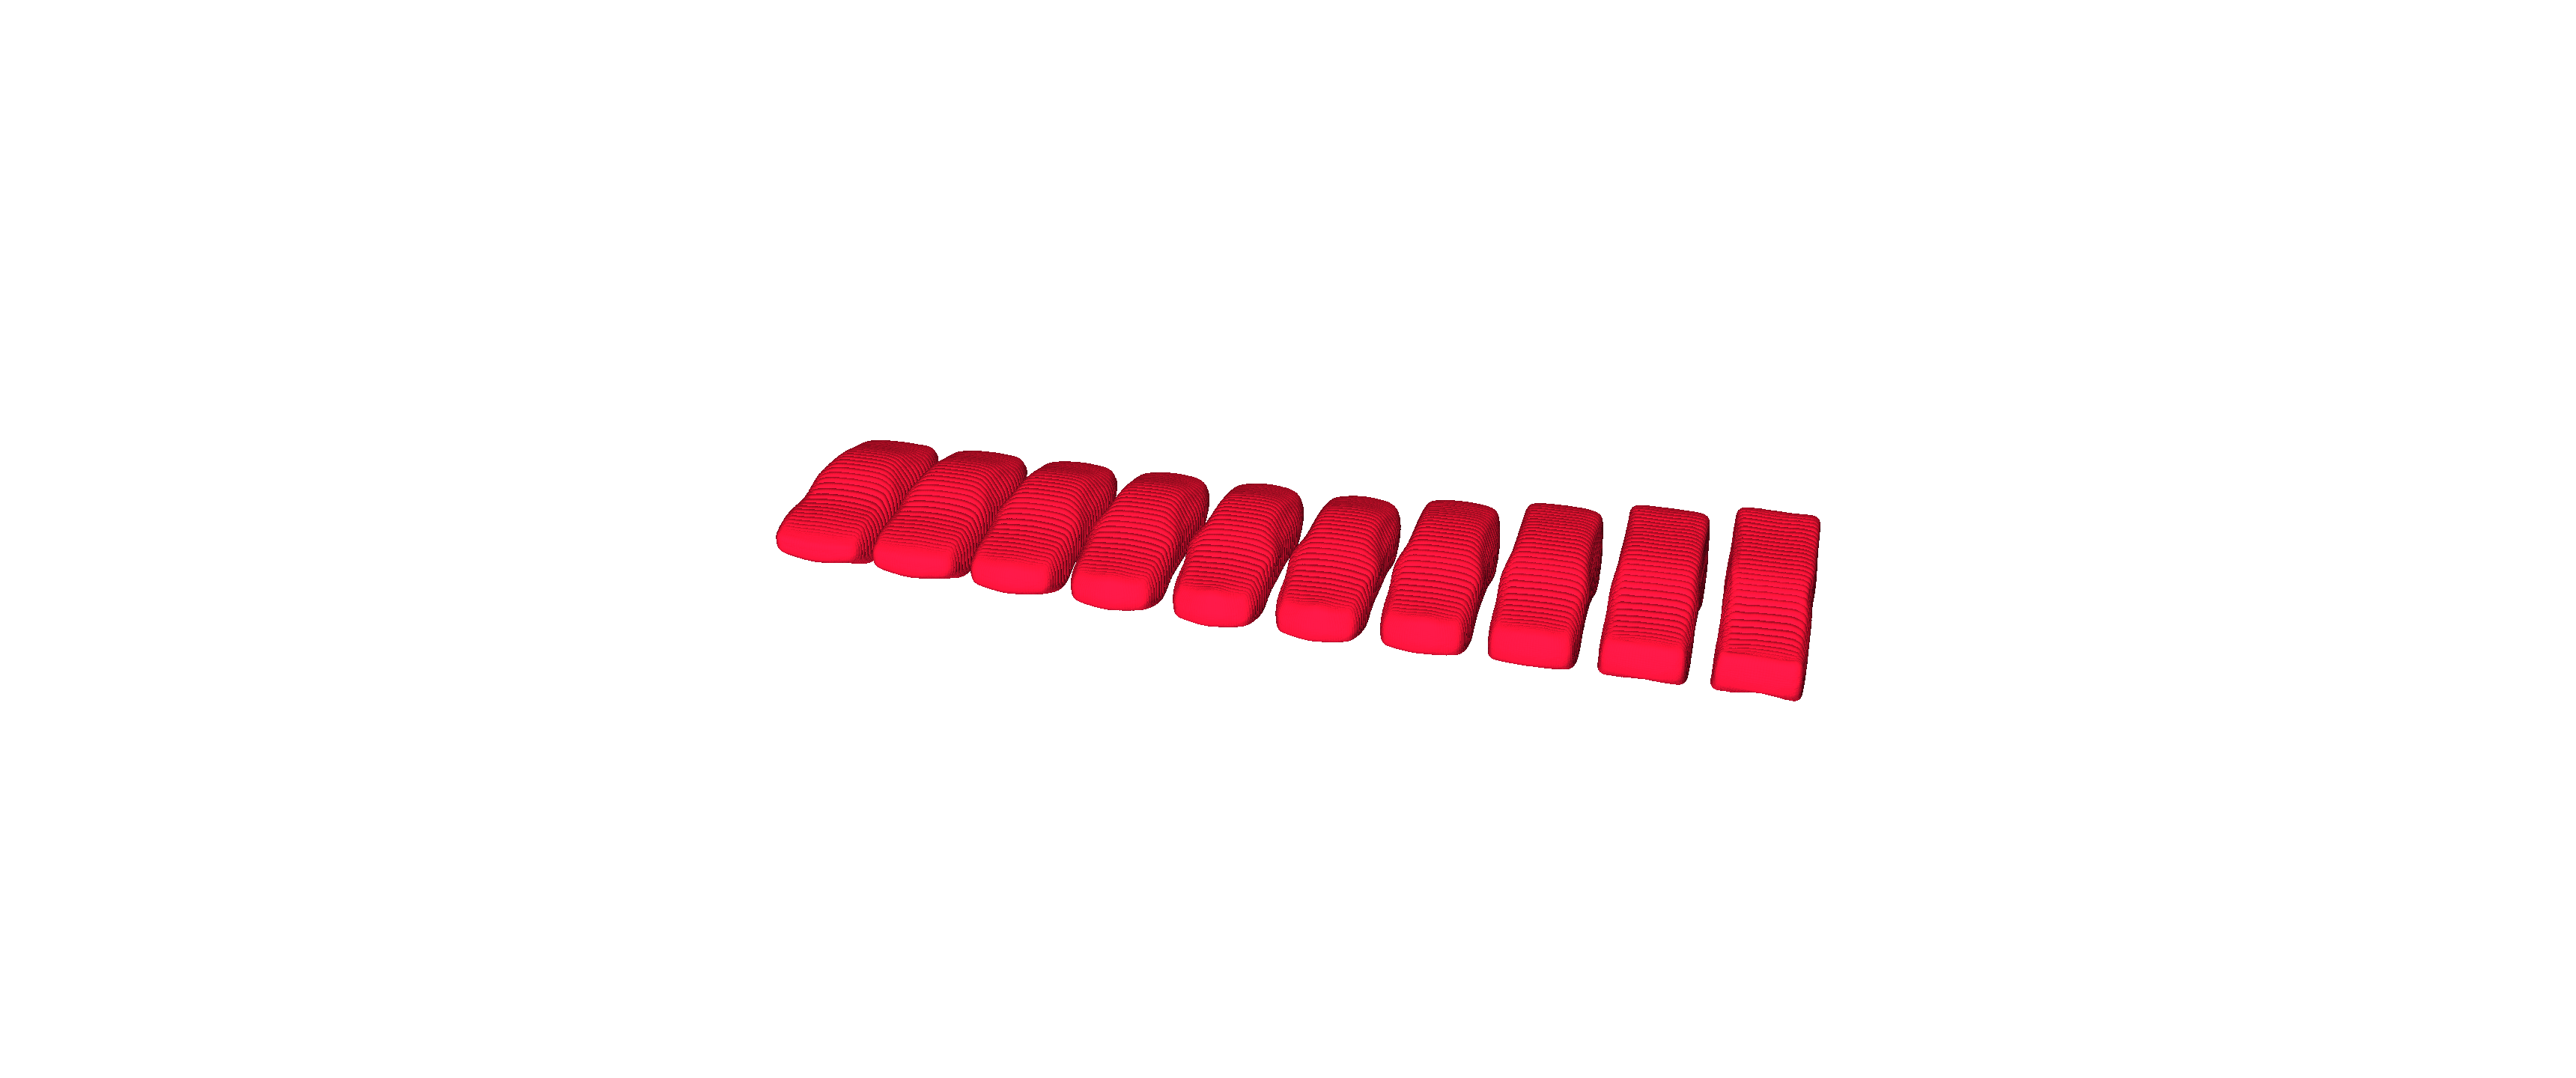

()

In [3]:
## Import libraries
import numpy as np
import pandas as pd
# Class for operating with the trained networks
from gdl4designapps.designapps import DesignApps
# Class for visualizing geometric data
from gdl4designapps.designapps import Vis3D

## Load learned latent representations
data_pc_ae = np.array(pd.read_csv("test_pc-ae/network_verification/network_verification.dat"))
# Select data samples
# !! Tip !!: You can also change the first index of `data_pc_ae` to interpolate other shapes
Z_1 = data_pc_ae[9, 1:129].astype(float)
Z_2 = data_pc_ae[73, 1:129].astype(float)
Z_3 = data_pc_ae[3105, 1:129].astype(float)

## Interpolate the latent representations
# Step size
interp_steps = np.linspace(0,1,5)
# Array to store the interpolated representations
Zint = np.zeros((interp_steps.shape[0]*2,128,1))
# Interpolation between Z_1 and Z_2
for i in range(interp_steps.shape[0]):
    Zint[i,:,0] = Z_1 + interp_steps[i]*(Z_2-Z_1)
# Interpolation between Z_2 and Z_3
for i in range(interp_steps.shape[0]):
    Zint[i+interp_steps.shape[0],:,0] = Z_2 + interp_steps[i]*(Z_3-Z_2)
    
## Reconstruct the 3Dpoint clouds
pcs = DesignApps.Z_to_pointcloud("pcae_training_config.py", Zint)
# Concatenate point clouds to ease the visualization
pcs_concat = np.array(np.reshape(pcs, (-1,3)))
for j in range(pcs.shape[0]):
    pcs_concat[j*pcs.shape[1]:(j+1)*pcs.shape[1],:] = pcs[j,:,:] + [0, j*2.2, 0]

# Shape visualization
Vis3D.pcplot(pcs_concat*[-1,-1,1], figname="test_pcae/network_verification/pc_interpolation", colorpoints="#c8102e", cam_az=15, cam_el=30)

The visualization shows the interpolated shapes from $Z_1$ (right) to $Z_2$ (middle) and finally to $Z_3$ (left). The size, colors and position of the camera can be changed either by manipulating the input parameters of the ``pcplot`` function or by enabling the interactive version of pyvista (check out [ipyvtklink](https://docs.pyvista.org/user-guide/jupyter/ipyvtk_plotting.html))

This is a standard example of how the function ``Z_to_pointcloud`` can be utilized to generate 3D point clouds from the random representations sampled from the latent space. In practice, optimization algorithms do not necessarily interpolate representations, but search the optimal combination of values for the latent features. Hence, ``Z_to_pointcloud`` can be added to optimization pipelines as shape-generative function.

## Example 2: Transfer of Selected Features

In this second example, we generate shapes by transferring specific features. We utilize this resource in our [multi-task framework](https://ieeexplore.ieee.org/abstract/document/9446541) in order to foster common geometric features in the optimized designs. In order to transfer the features, we utilize the following algorithm:

1. Load the necessary libraries (in this jupyter notebook, the libraries were loaded in the previous step)
2. Select two shapes ($S_0$, $S_1$)
3. Visualize the learned features
4. Generate the corresponding latent representations for the shapes
5. Exchange features between latent representations ($Z_0$ $\rightarrow$ $S_1$)
6. Reconstruct the 3D point clouds

The described algorithm is equivalent to the following script in Python:

INFO:tensorflow:Restoring parameters from ./test_pc-ae/pcae


INFO:tensorflow:Restoring parameters from ./test_pc-ae/pcae


Initial Shape


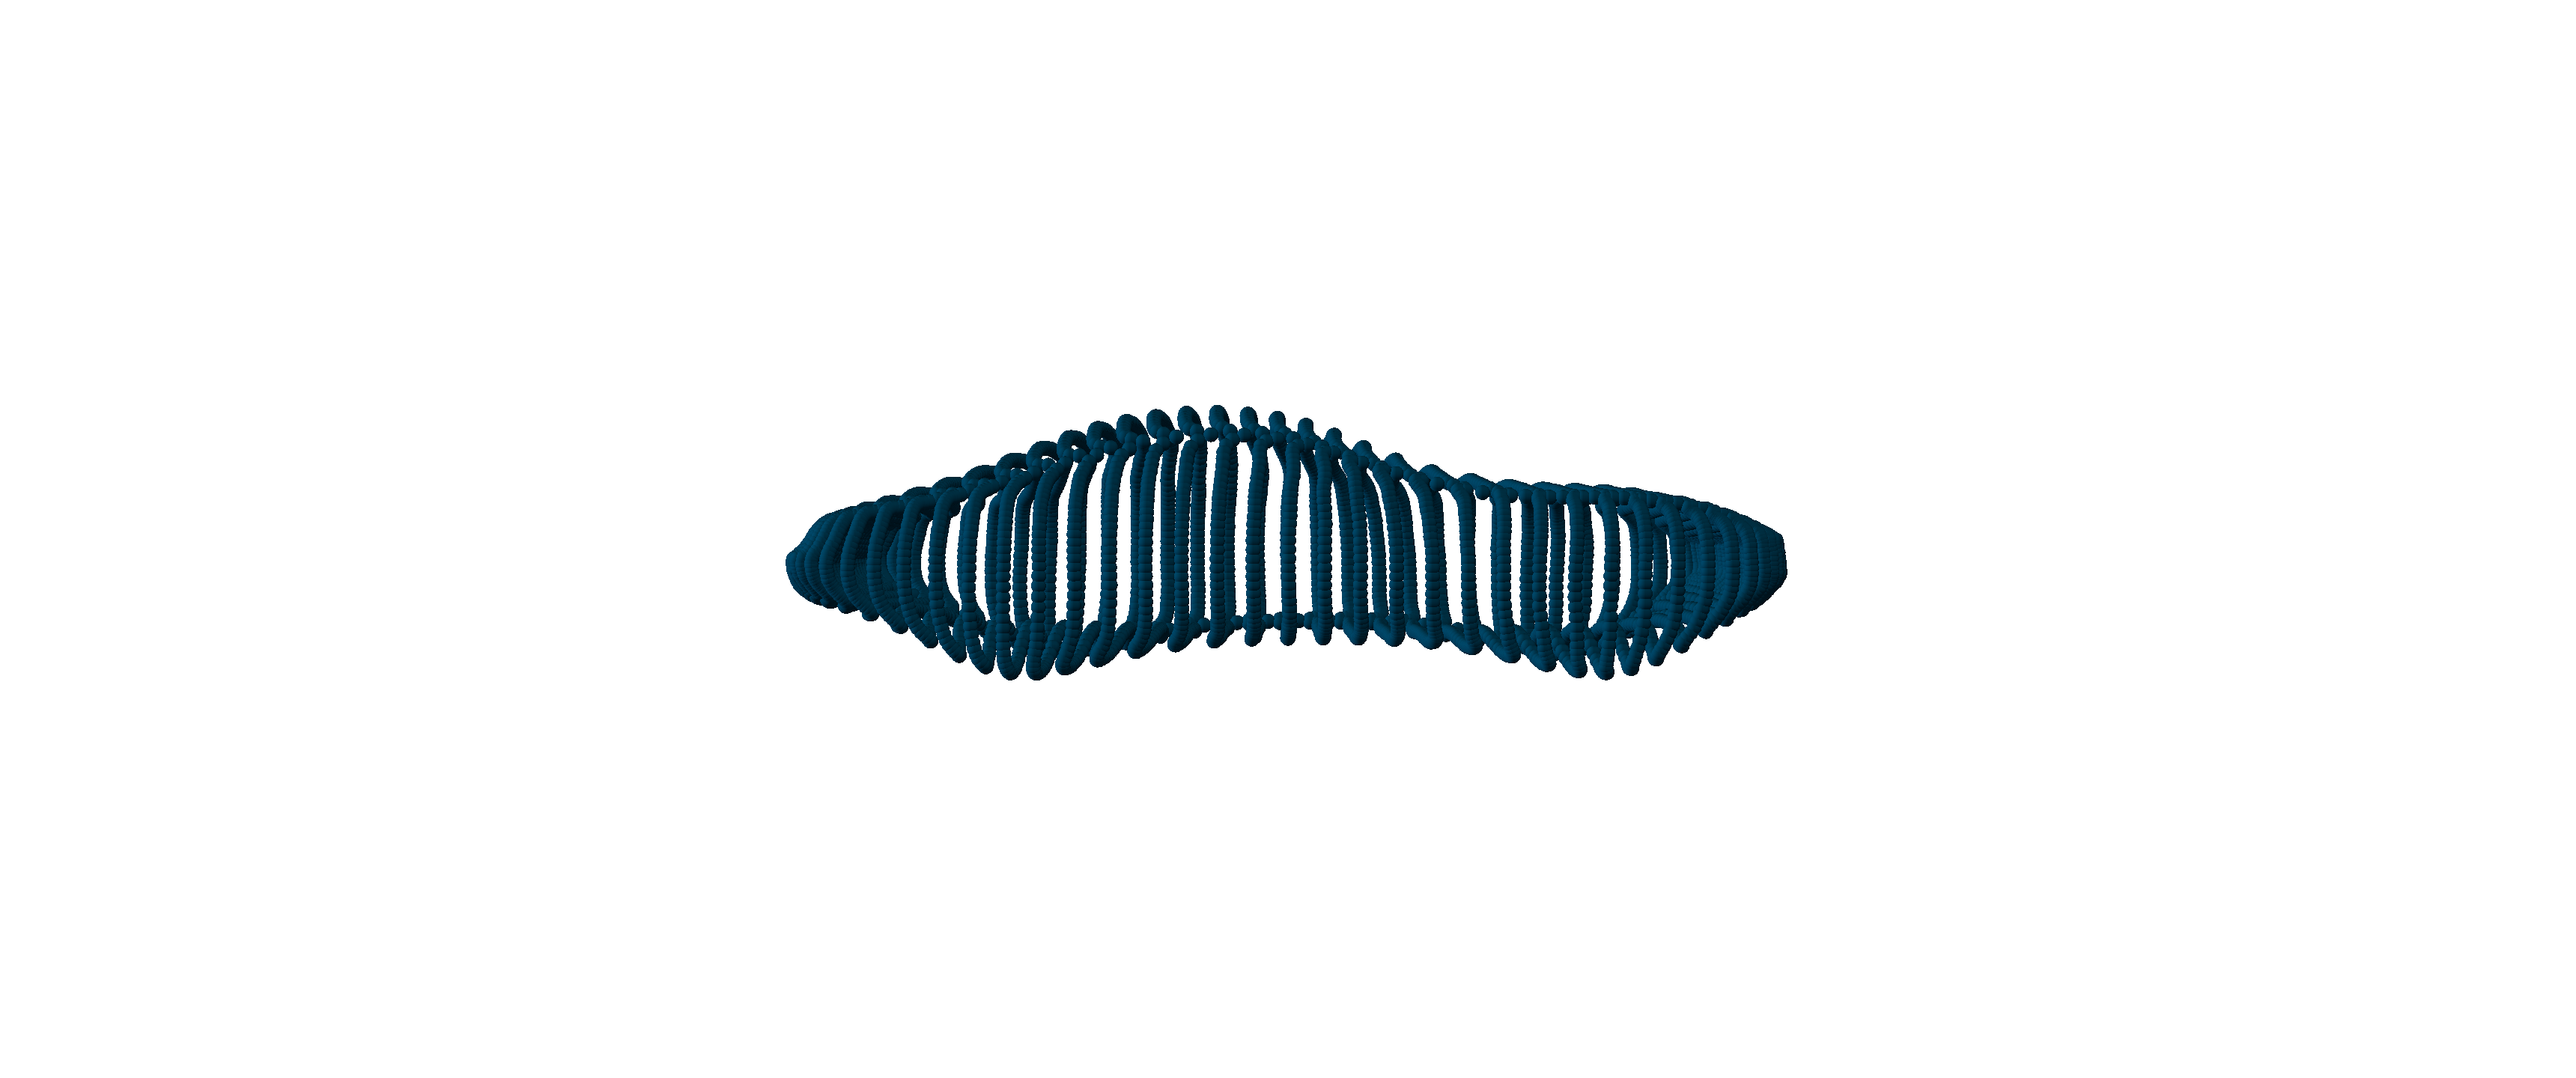

Shape with targeted features


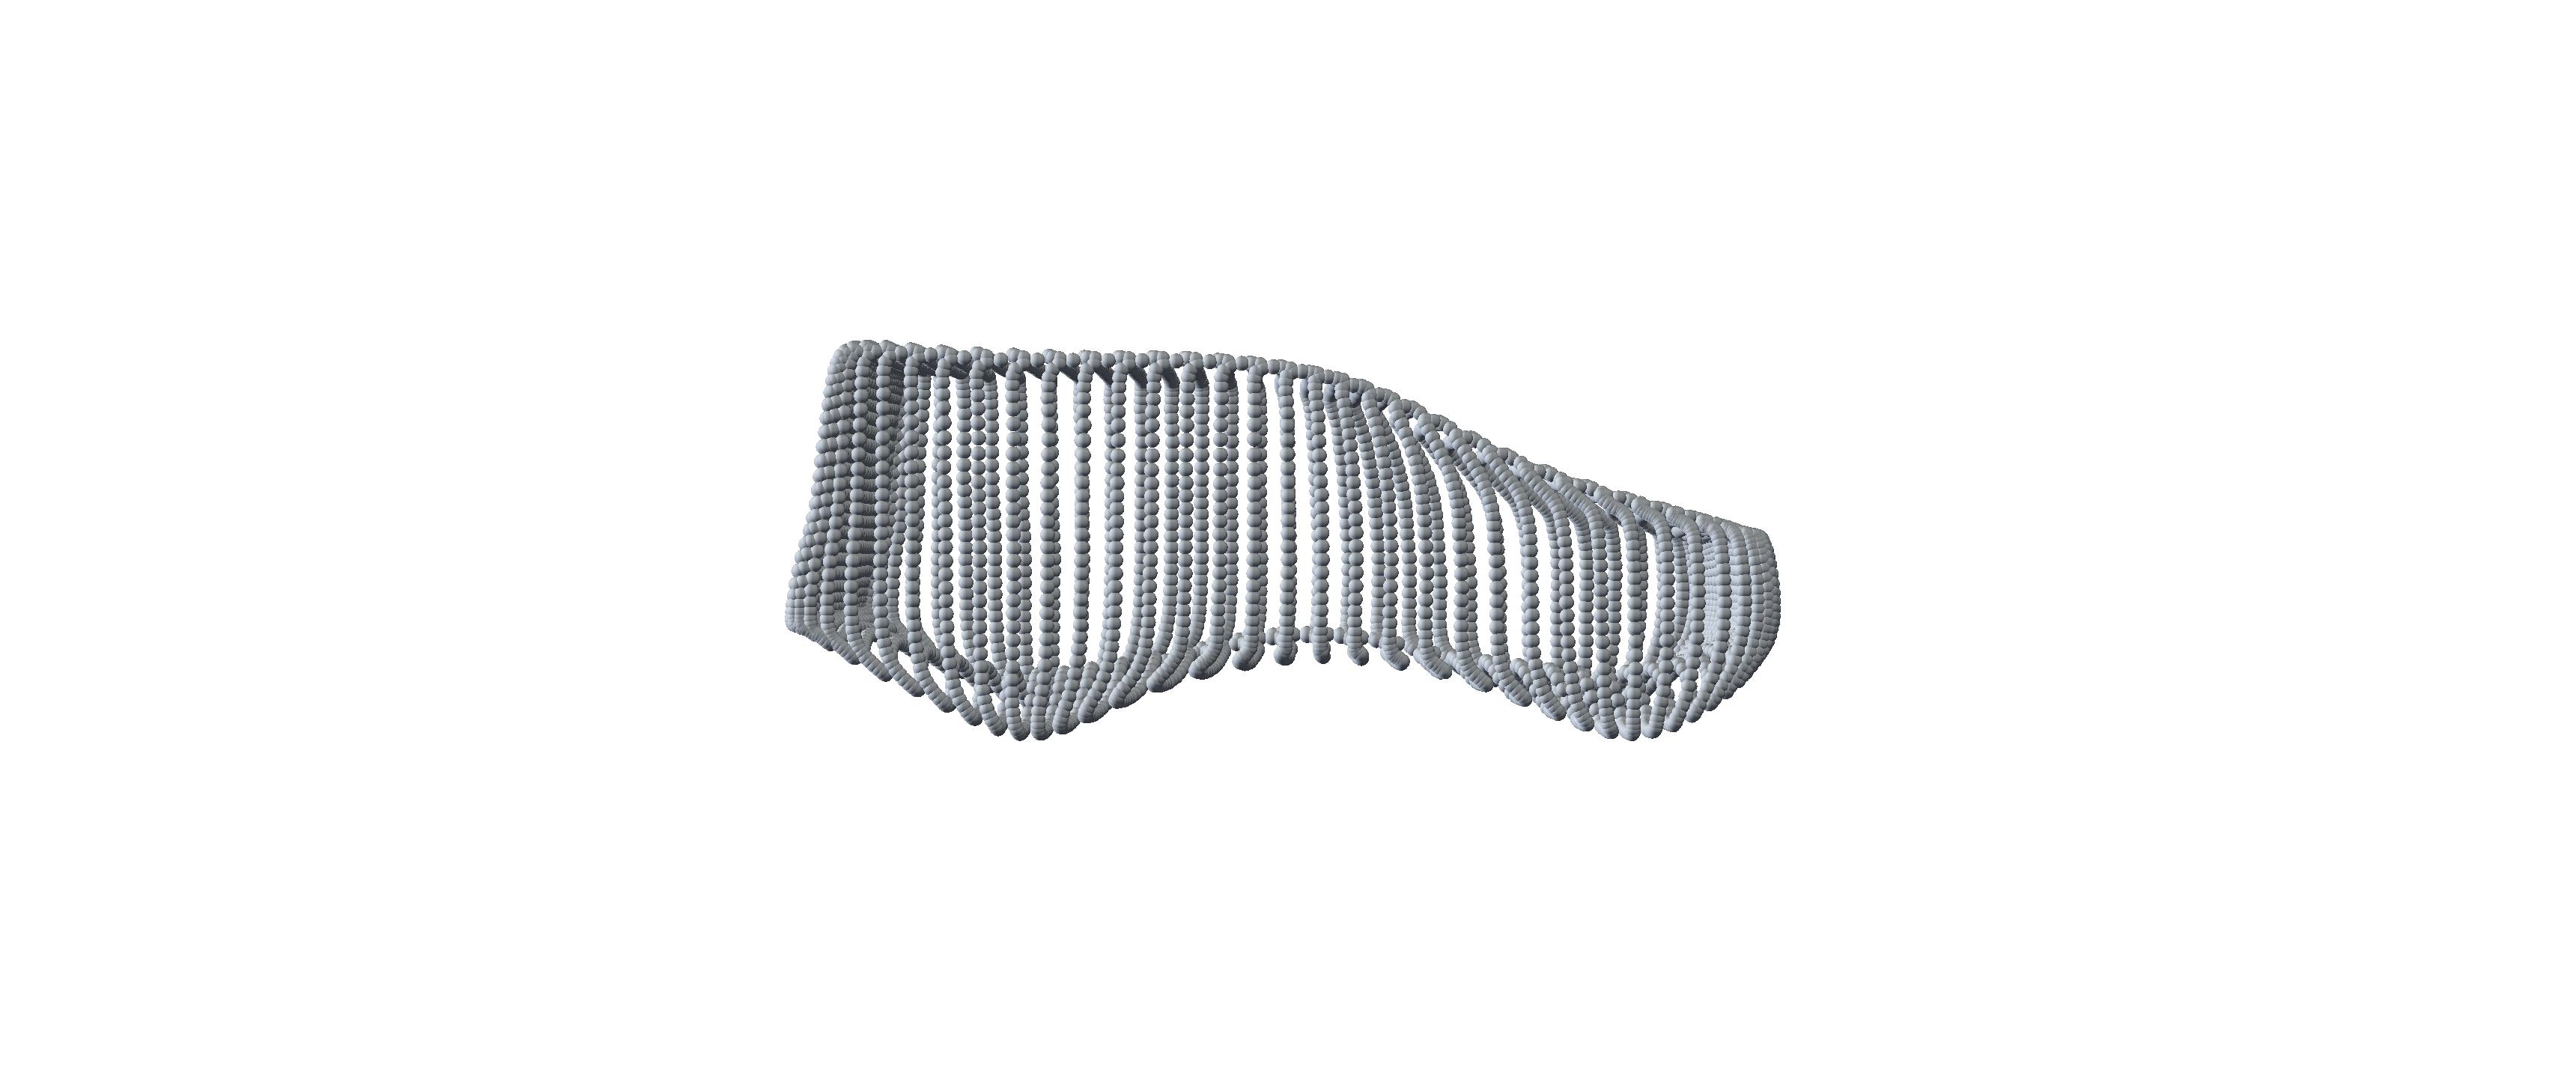

Shape with transferred features


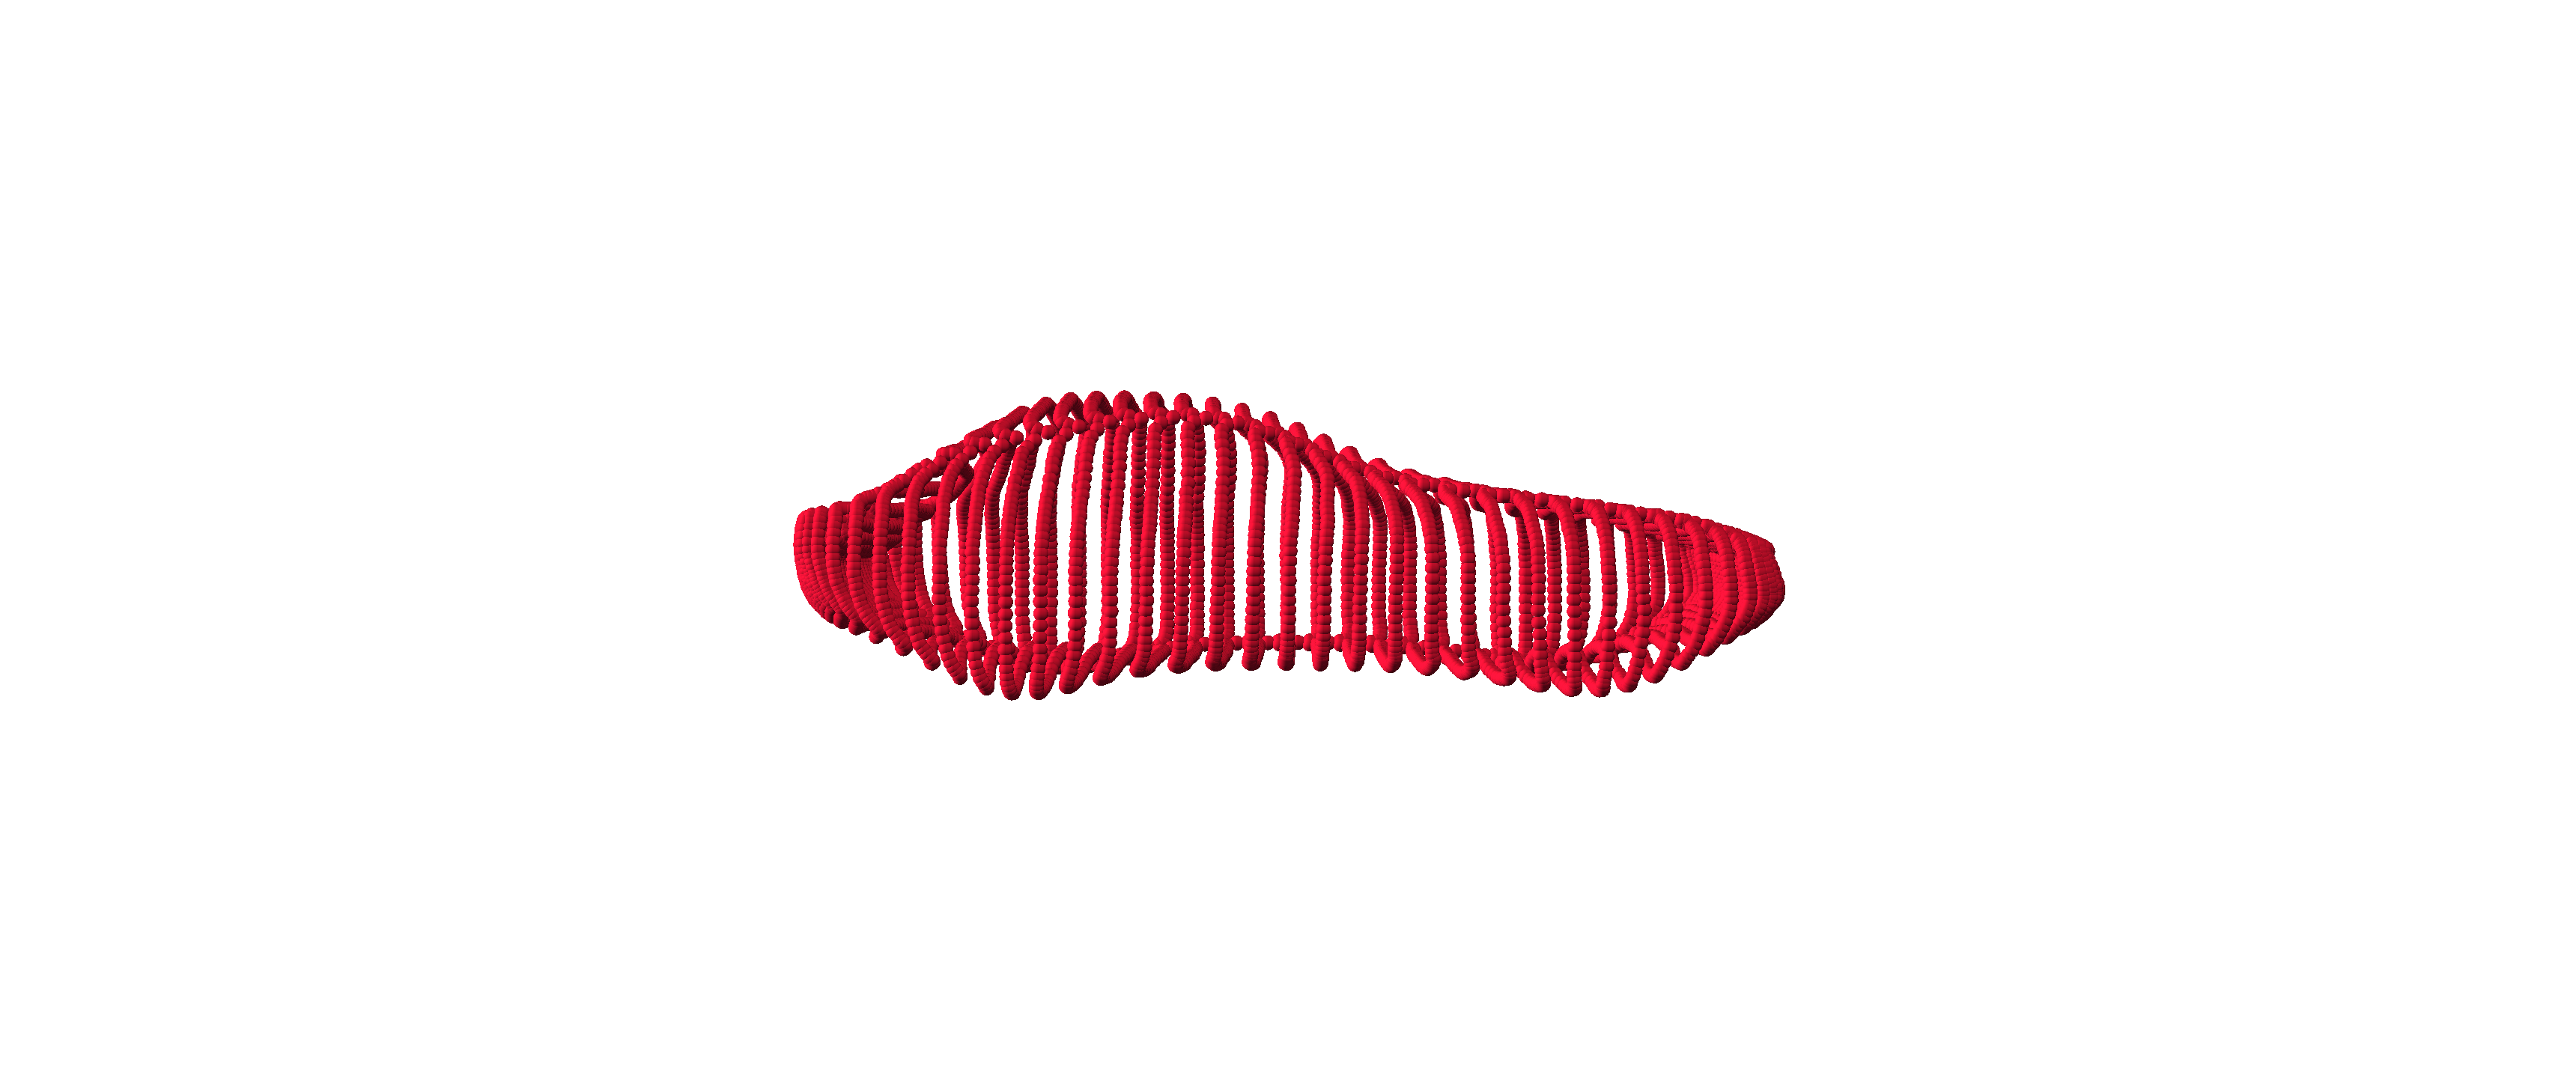

()

In [4]:
## Select the 3D point clouds
# in this case, we utilize the first and last interpolated shapes
pcs_initial = pcs[[0,pcs.shape[0]-1],:,:]

## Visualize the latent features
# In this case, we pre-visualized the features and display here the ones the map the rear of the car shapes.
feat_rear = [0, 8, 9, 10, 11, 12, 14, 15, 22, 53]
print("Selected features")
feat_batch = DesignApps.featvis("pcae_training_config.py", pcs_initial, sel_feat=feat_rear)

## Generate latent representations
Z_batch = DesignApps.pointcloud_to_Z("pcae_training_config.py", pcs_initial)

## Transfer latent features from Z_0 to Z_1
Z_transfer = np.array(Z_batch[[1,],:,:])
Z_transfer[0,feat_rear,:] = Z_batch[0, feat_rear,:]

## Reconstruct Point cloud
pc_transfer = DesignApps.Z_to_pointcloud("pcae_training_config.py", Z_transfer)[0,:,:]

## Visualize point clouds
print("Initial Shape")
Vis3D.pcplot(pcs_initial[1,:,:], figname="test_pcae/network_verification/pc_transfer_before", colorpoints="#00334c", cam_az=90, cam_el=0)
print("Shape with targeted features")
Vis3D.pcplot(pcs_initial[0,:,:], figname="test_pcae/network_verification/pc_transfer_target", colorpoints="#959da8", cam_az=90, cam_el=0)
print("Shape with transferred features")
Vis3D.pcplot(pc_transfer, figname="test_pcae/network_verification/pc_transfer_after", colorpoints="#c8102e", cam_az=90, cam_el=0)